In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import libs.batch_norm as bn
from libs.utils import *

In [2]:
from libs.datasets import CELEB
files = CELEB()

In [3]:
# Inpput pipeline
from libs.dataset_utils import create_input_pipeline
batch_size = 100
n_epochs = 10
input_shape = [218, 178, 3]
crop_shape = [64, 64, 3]
crop_factor = 0.8
batch = create_input_pipeline(
    files=files,
    batch_size=batch_size,
    n_epochs=n_epochs,
    crop_shape=crop_shape,
    crop_factor=crop_factor,
    shape=input_shape)

In [4]:
sess = tf.Session()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

(100, 64, 64, 3)
(dtype('float32'), dtype('float32'))


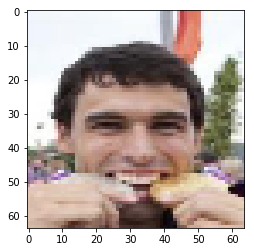

In [5]:
batch_xs = sess.run(batch)
# We get batch_size at a time, so 100
print(batch_xs.shape)
# The datatype is float32 since what is what we use in the tensorflow graph
# And the max value still has the original image range from 0-255
print(batch_xs.dtype, np.max(batch_xs.dtype))
# So to plot it, we'll need to divide by 255.
plt.imshow(batch_xs[0] / 255.0)
#plt.show()

In [8]:
def encoder(x, phase_train, dimensions=[], filter_sizes=[],
            convolutional=False, activation=tf.nn.relu,
            output_activation=tf.nn.sigmoid, reuse=False):
    """Encoder network codes input `x` to layers defined by dimensions.

    Parameters
    ----------
    x : tf.Tensor
        Input to the encoder network, e.g. tf.Placeholder or tf.Variable
    phase_train : tf.Placeholder
        Placeholder defining whether the network is in train mode or not.
        Used for changing the behavior of batch normalization which updates
        its statistics during train mode.
    dimensions : list, optional
        List of the number of neurons in each layer (convolutional=False) -or-
        List of the number of filters in each layer (convolutional=True), e.g.
        [100, 100, 100, 100] for a 4-layer deep network with 100 in each layer.
    filter_sizes : list, optional
        List of the size of the kernel in each layer, e.g.:
        [3, 3, 3, 3] is a 4-layer deep network w/ 3 x 3 kernels in every layer.
    convolutional : bool, optional
        Whether or not to use convolutional layers.
    activation : fn, optional
        Function for applying an activation, e.g. tf.nn.relu
    output_activation : fn, optional
        Function for applying an activation on the last layer, e.g. tf.nn.relu
    reuse : bool, optional
        For each layer's variable scope, whether to reuse existing variables.

    Returns
    -------
    h : tf.Tensor
        Output tensor of the encoder
    """
    # %%
    # ensure 2-d is converted to square tensor.
    if convolutional:
        x_tensor = to_tensor(x)
    else:
        x_tensor = tf.reshape(
            tensor=x,
            shape=[-1, dimensions[0]])
        dimensions = dimensions[1:]
    current_input = x_tensor

    for layer_i, n_output in enumerate(dimensions):
        with tf.variable_scope(str(layer_i), reuse=reuse):
            if convolutional:
                h, W = conv2d(
                    x=current_input,
                    n_output=n_output,
                    k_h=filter_sizes[layer_i],
                    k_w=filter_sizes[layer_i],
                    padding='SAME',
                    reuse=reuse)
            else:
                h, W = linear(
                    x=current_input,
                    n_output=n_output,
                    reuse=reuse)
            norm = bn.batch_norm(
                x=h,
                phase_train=phase_train,
                name='bn',
                reuse=reuse)
            output = activation(norm)

        current_input = output

    flattened = flatten(current_input, name='flatten', reuse=reuse)

    if output_activation is None:
        return flattened
    else:
        return output_activation(flattened)


def decoder(z,
            phase_train,
            dimensions=[],
            channels=[],
            filter_sizes=[],
            convolutional=False,
            activation=tf.nn.relu,
            output_activation=tf.nn.tanh,
            reuse=None):
    """Decoder network codes input `x` to layers defined by dimensions.

    In contrast with `encoder`, this requires information on the number of
    output channels in each layer for convolution.  Otherwise, it is mostly
    the same.

    Parameters
    ----------
    z : tf.Tensor
        Input to the decoder network, e.g. tf.Placeholder or tf.Variable
    phase_train : tf.Placeholder
        Placeholder defining whether the network is in train mode or not.
        Used for changing the behavior of batch normalization which updates
        its statistics during train mode.
    dimensions : list, optional
        List of the number of neurons in each layer (convolutional=False) -or-
        List of the number of filters in each layer (convolutional=True), e.g.
        [100, 100, 100, 100] for a 4-layer deep network with 100 in each layer.
    channels : list, optional
        For decoding when convolutional=True, require the number of output
        channels in each layer.
    filter_sizes : list, optional
        List of the size of the kernel in each layer, e.g.:
        [3, 3, 3, 3] is a 4-layer deep network w/ 3 x 3 kernels in every layer.
    convolutional : bool, optional
        Whether or not to use convolutional layers.
    activation : fn, optional
        Function for applying an activation, e.g. tf.nn.relu
    output_activation : fn, optional
        Function for applying an activation on the last layer, e.g. tf.nn.relu
    reuse : bool, optional
        For each layer's variable scope, whether to reuse existing variables.

    Returns
    -------
    h : tf.Tensor
        Output tensor of the decoder
    """

    if convolutional:
        with tf.variable_scope('fc', reuse=reuse):
            z1, W = linear(
                x=z,
                n_output=channels[0] * dimensions[0][0] * dimensions[0][1],
                reuse=reuse)
            rsz = tf.reshape(
                z1, [-1, dimensions[0][0], dimensions[0][1], channels[0]])
            current_input = activation(
                features=bn.batch_norm(
                    name='bn',
                    x=rsz,
                    phase_train=phase_train,
                    reuse=reuse))

        dimensions = dimensions[1:]
        channels = channels[1:]
        filter_sizes = filter_sizes[1:]
    else:
        current_input = z

    for layer_i, n_output in enumerate(dimensions):
        with tf.variable_scope(str(layer_i), reuse=reuse):

            if convolutional:
                h, W = deconv2d(
                    x=current_input,
                    n_output_h=n_output[0],
                    n_output_w=n_output[1],
                    n_output_ch=channels[layer_i],
                    k_h=filter_sizes[layer_i],
                    k_w=filter_sizes[layer_i],
                    padding='SAME',
                    reuse=reuse)
            else:
                h, W = linear(
                    x=current_input,
                    n_output=n_output,
                    reuse=reuse)

            if layer_i < len(dimensions) - 1:
                norm = bn.batch_norm(
                    x=h,
                    phase_train=phase_train,
                    name='bn', reuse=reuse)
                output = activation(norm)
            else:
                output = h
        current_input = output

    if output_activation is None:
        return current_input
    else:
        return output_activation(current_input)


def generator(z, phase_train, output_h, output_w, convolutional=True,
              n_features=32, rgb=False, reuse=None):
    """Simple interface to build a decoder network given the input parameters.
    
    Parameters
    ----------
    z : tf.Tensor
        Input to the generator, i.e. tf.Placeholder of tf.Variable
    phase_train : tf.Placeholder of type bool
        Whether or not the network should be trained (used for Batch Norm).
    output_h : int
        Final generated height
    output_w : int
        Final generated width
    convolutional : bool, optional
        Whether or not to build a convolutional generative network.
    n_features : int, optional
        Number of channels to use in the last hidden layer.
    rgb : bool, optional
        Whether or not the final generated image is RGB or not.
    reuse : None, optional
        Whether or not to reuse the variables if they are already created.
    
    Returns
    -------
    x_tilde : tf.Tensor
        Output of the generator network.
    """
    n_channels = 3 if rgb else 1
    with tf.variable_scope('generator', reuse=reuse):
        return decoder(z=z,
                       phase_train=phase_train,
                       convolutional=convolutional,
                       filter_sizes=[5, 5, 5, 5, 5],
                       channels=[n_features * 8, n_features * 4,
                                 n_features * 2, n_features, n_channels],
                       dimensions=[
                           [output_h // 16, output_w // 16],
                           [output_h // 8, output_w // 8],
                           [output_h // 4, output_w // 4],
                           [output_h // 2, output_w // 2],
                           [output_h, output_w]]
                       if convolutional else [384, 512, n_features],
                       activation=tf.nn.relu6,
                       output_activation=tf.nn.tanh,
                       reuse=reuse)


def discriminator(x, phase_train, convolutional=True,
                  n_features=32, rgb=False, reuse=False):
    """Summary
    
    Parameters
    ----------
    x : TYPE
        Description
    phase_train : TYPE
        Description
    convolutional : bool, optional
        Description
    n_features : int, optional
        Description
    rgb : bool, optional
        Description
    reuse : bool, optional
        Description
    
    Returns
    -------
    name : TYPE
        Description
    """
    n_channels = 3 if rgb else 1
    with tf.variable_scope('discriminator', reuse=reuse):
        return encoder(x=x,
                       phase_train=phase_train,
                       convolutional=convolutional,
                       filter_sizes=[5, 5, 5, 5],
                       dimensions=[n_features, n_features * 2,
                                   n_features * 4, n_features * 8]
                       if convolutional
                       else [n_features, 128, 256],
                       activation=tf.nn.relu6,
                       output_activation=None,
                       reuse=reuse)


def GAN(input_shape, n_latent, n_features, rgb, debug=True):
    """Summary
    
    Parameters
    ----------
    input_shape : TYPE
        Description
    n_latent : TYPE
        Description
    n_features : TYPE
        Description
    rgb : TYPE
        Description
    debug : bool, optional
        Description
    
    Returns
    -------
    name : TYPE
        Description
    """
    # Real input samples
    # n_features is either the image dimension or flattened number of features
    x = tf.placeholder(tf.float32, input_shape, 'x')
    x = (x / 127.5) - 1.0
    #sum_x = tf.image_summary("x", x)
    phase_train = tf.placeholder(tf.bool, name='phase_train')

    # Discriminator for real input samples
    D_real_logits = discriminator(
        x, phase_train, n_features=n_features, rgb=rgb)
    D_real = tf.nn.sigmoid(D_real_logits)
    #sum_D_real = tf.histogram_summary("D_real", D_real)

    # Generator tries to recreate input samples using latent feature vector
    z = tf.placeholder(tf.float32, [None, n_latent], 'z')
    #sum_z = tf.histogram_summary("z", z)
    G = generator(
        z, phase_train,
        output_h=input_shape[1], output_w=input_shape[2],
        n_features=n_features, rgb=rgb)
    #sum_G = tf.image_summary("G", G)

    # Discriminator for generated samples
    D_fake_logits = discriminator(
        G, phase_train, n_features=n_features, rgb=rgb, reuse=True)
    D_fake = tf.nn.sigmoid(D_fake_logits)
    #sum_D_fake = tf.histogram_summary("D_fake", D_fake)

    with tf.variable_scope('loss'):
        # Loss functions
        loss_D_real = binary_cross_entropy(
            D_real, tf.ones_like(D_real), name='loss_D_real')
        loss_D_fake = binary_cross_entropy(
            D_fake, tf.zeros_like(D_fake), name='loss_D_fake')
        loss_D = tf.reduce_mean((loss_D_real + loss_D_fake) / 2)
        loss_G = tf.reduce_mean(binary_cross_entropy(
            D_fake, tf.ones_like(D_fake), name='loss_G'))
        '''
        # Summaries
        sum_loss_D_real = tf.histogram_summary("loss_D_real", loss_D_real)
        sum_loss_D_fake = tf.histogram_summary("loss_D_fake", loss_D_fake)
        sum_loss_D = tf.scalar_summary("loss_D", loss_D)
        sum_loss_G = tf.scalar_summary("loss_G", loss_G)
        sum_D_real = tf.histogram_summary("D_real", D_real)
        sum_D_fake = tf.histogram_summary("D_fake", D_fake)
        '''


    return {
        'loss_D': loss_D,
        'loss_G': loss_G,
        'x': x,
        'G': G,
        'z': z,
        'train': phase_train}


In [9]:
init_lr_g = 1e-4
init_lr_d = 1e-4
n_latent = 100
n_epochs = 1000000
batch_size = 200
n_samples = 15
input_shape = [218, 178, 3]
crop_shape = [64, 64, 3]
crop_factor = 0.8

In [10]:
gan = GAN(input_shape=[None] + crop_shape, n_features=10, n_latent=n_latent, rgb=True, debug=False)

In [11]:
vari_d, vari_g = [], []
vars_d = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')] 
print('Training discriminator variables:')
[vari_d.append((v.name)) for v in tf.trainable_variables() if v.name.startswith('discriminator')]
print vari_d

Training discriminator variables:
[u'discriminator/0/conv2d/W:0', u'discriminator/0/conv2d/b:0', u'discriminator/0/bn/beta:0', u'discriminator/0/bn/gamma:0', u'discriminator/1/conv2d/W:0', u'discriminator/1/conv2d/b:0', u'discriminator/1/bn/beta:0', u'discriminator/1/bn/gamma:0', u'discriminator/2/conv2d/W:0', u'discriminator/2/conv2d/b:0', u'discriminator/2/bn/beta:0', u'discriminator/2/bn/gamma:0', u'discriminator/3/conv2d/W:0', u'discriminator/3/conv2d/b:0', u'discriminator/3/bn/beta:0', u'discriminator/3/bn/gamma:0']


In [12]:
vars_g = [v for v in tf.trainable_variables() if v.name.startswith('generator')]
print('Training generator variables:')
[vari_g.append(v.name) for v in tf.trainable_variables() if v.name.startswith('generator')]
print vari_g

Training generator variables:
[u'generator/fc/fc/W:0', u'generator/fc/fc/b:0', u'generator/fc/bn/beta:0', u'generator/fc/bn/gamma:0', u'generator/0/deconv2d/W:0', u'generator/0/deconv2d/b:0', u'generator/0/bn/beta:0', u'generator/0/bn/gamma:0', u'generator/1/deconv2d/W:0', u'generator/1/deconv2d/b:0', u'generator/1/bn/beta:0', u'generator/1/bn/gamma:0', u'generator/2/deconv2d/W:0', u'generator/2/deconv2d/b:0', u'generator/2/bn/beta:0', u'generator/2/bn/gamma:0', u'generator/3/deconv2d/W:0', u'generator/3/deconv2d/b:0']


In [13]:
zs = np.random.uniform(
        -1.0, 1.0, [4, n_latent]).astype(np.float32)
zs = make_latent_manifold(zs, n_samples)

lr_g = tf.placeholder(tf.float32, shape=[], name='learning_rate_g')
lr_d = tf.placeholder(tf.float32, shape=[], name='learning_rate_d')

In [ ]:
try:
    from tf.contrib.layers import apply_regularization
    d_reg = apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_d)
    g_reg = apply_regularization(tf.contrib.layers.l2_regularizer(1e-6), vars_g)
except:
    d_reg, g_reg = 0, 0

In [15]:
opt_g = tf.train.AdamOptimizer(lr_g, name='Adam_g').minimize(gan['loss_G'], var_list=vars_g) #gan['loss_G'] + g_reg
opt_d = tf.train.AdamOptimizer(lr_d, name='Adam_d').minimize(gan['loss_D'], var_list=vars_d)

# %%
# We create a session to use the graph
sess = tf.Session()
init_op = tf.initialize_all_variables()

saver = tf.train.Saver()
#sums = gan['sums']
#G_sum_op = tf.merge_summary([sums['G'], sums['loss_G'], sums['z'], sums['loss_D_fake'], sums['D_fake']])
#D_sum_op = tf.merge_summary([sums['loss_D'], sums['loss_D_real'], sums['loss_D_fake'],
#        sums['z'], sums['x'], sums['D_real'], sums['D_fake']])
#writer = tf.train.SummaryWriter("./logs", sess.graph_def)

coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)
sess.run(init_op)

In [16]:
if os.path.exists("gan.ckpt"):
    saver.restore(sess, "gan.ckpt")
    print("GAN model restored.")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
step_i, t_i = 0, 0
loss_d = 1
loss_g = 1
n_loss_d, total_loss_d = 1, 1
n_loss_g, total_loss_g = 1, 1
try:
    while not coord.should_stop():
        batch_xs = sess.run(batch)
        step_i += 1
        batch_zs = np.random.uniform(-1.0, 1.0, [batch_size, n_latent]).astype(np.float32)
        
        print '1st step', np.shape(batch_zs)
        

        this_lr_g = min(1e-2, max(1e-6, init_lr_g * (loss_g / loss_d)**2))
        this_lr_d = min(1e-2, max(1e-6, init_lr_d * (loss_d / loss_g)**2))
        
        print 'lr_g', this_lr_g
        print 'lr_d', this_lr_d
        # this_lr_d *= ((1.0 - (step_i / 100000)) ** 2)
        # this_lr_g *= ((1.0 - (step_i / 100000)) ** 2)

        # if np.random.random() > (loss_g / (loss_d + loss_g)):
        #if step_i % 3 == 1:
        loss_d, _ = sess.run([gan['loss_D'], opt_d],
                                        feed_dict={gan['x']: batch_xs,
                                                   gan['z']: batch_zs,
                                                   gan['train']: True,
                                                   lr_d: this_lr_d})
        total_loss_d += loss_d
        n_loss_d += 1
            #writer.add_summary(sum_d, step_i)
        print('%04d d* = lr: %0.08f, loss: %08.06f, \t' %
                      (step_i, this_lr_d, loss_d) +
                      'g  = lr: %0.08f, loss: %08.06f' % (this_lr_g, loss_g))
        #else:
        loss_g, _ = sess.run([gan['loss_G'], opt_g],
                                        feed_dict={gan['z']: batch_zs,
                                                    gan['train']: True,
                                                    lr_g: this_lr_g})
        total_loss_g += loss_g
        n_loss_g += 1
            #writer.add_summary(sum_g, step_i)
        print('%04d d  = lr: %0.08f, loss: %08.06f, \t' %
                      (step_i, this_lr_d, loss_d) +
                      'g* = lr: %0.08f, loss: %08.06f' % (this_lr_g, loss_g))

        if step_i % 100 == 0:
            samples = sess.run(gan['G'], feed_dict={
                gan['z']: zs,
                gan['train']: False})
            montage(np.clip((samples + 1) * 127.5, 0, 255).astype(np.uint8), 'imgs/gan_%08d.png' % t_i)
            t_i += 1

            print('generator loss:', total_loss_g / n_loss_g)
            print('discriminator loss:', total_loss_d / n_loss_d)

            # Save the variables to disk.
            save_path = saver.save(sess, "./gan.ckpt",
                                   global_step=step_i,
                                   write_meta_graph=False)
            print("Model saved in file: %s" % save_path)
except tf.errors.OutOfRangeError:
    print('Done training -- epoch limit reached')
finally:
    # One of the threads has issued an exception.  So let's tell all the
    # threads to shutdown.
    coord.request_stop()

# Wait until all threads have finished.
coord.join(threads)

# Clean up the session.
sess.close()